시계열 수치를 입력해서 다음 수치를 예측하는 모델들에 대해서 알아보겠습니다. 각 모델에 코사인(cosine) 데이터를 학습시킨 후, 처음 일부 데이터를 알려주면 이후 코사인 형태의 데이터 예측을 얼마나 잘 하는 지 테스트 하겠습니다.

---
### 데이터셋 준비

먼저 코사인 데이터를 만들어보겠습니다. 시간의 흐름에 따라 진폭이 -1.0에서 1.0사이로 변하는 1,600개의 실수값을 생성합니다.

In [1]:
import numpy as np

signal_data = np.cos(np.arange(1600)*(20*np.pi/1000))[:,None]

생성한 데이터를 확인해보겠습니다.

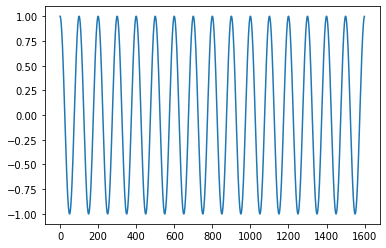

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

plot_x = np.arange(1600)
plot_y = signal_data
plt.plot(plot_x, plot_y)
plt.show()

![img](http://tykimos.github.io/warehouse/2017-9-9-Time-series_Numerical_Input_Numerical_Prediction_Model_Recipe_5_0.png)

생성한 코사인 데이터를 모델에 학습시키기 위해서는 데이터와 라벨로 구성된 데이터셋으로 만들어야 합니다. 이전 수치들을 입력하여 다음 수치를 예측하는 문제이므로 데이터는 이전 수치들이 되고, 라벨은 다음 수치가 됩니다. 다른 예제들과는 달리 데이터와 라벨이 모두 같은 속성입니다. 아래 create_dataset() 함수는 시계열 수치를 입력받아 데이터셋을 생성합니다. 이 때 look_back 인자는 얼마만큼의 이전 수치를 데이터로 만들것인가를 결정합니다.

In [3]:
def create_dataset(signal_data, look_back=1):
    dataX, dataY = [], []
    for i in range(len(signal_data)-look_back):
        dataX.append(signal_data[i:(i+look_back), 0])
        dataY.append(signal_data[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

-1.0에서 1.0까지의 값을 가지는 코사인 데이터를 0.0과 1.0 사이의 값을 가지도록 정규화를 한 뒤 훈련셋과 시험셋으로 분리합니다. 이전 40개의 수치를 입력하여 다음 수치 1개를 예측하는 데이터셋을 만들기 위해 look_back 인자를 40으로 설정하였습니다. look_back 인자에 따라 모델의 성능이 달라지므로 적정 값을 지정하는 것이 중요합니다.

In [4]:
from sklearn.preprocessing import MinMaxScaler

look_back = 40

# 데이터 전처리
scaler = MinMaxScaler(feature_range=(0, 1))
signal_data = scaler.fit_transform(signal_data)

# 데이터 분리
train = signal_data[0:800]
val = signal_data[800:1200]
test = signal_data[1200:]

# 데이터셋 생성
x_train, y_train = create_dataset(train, look_back)
x_val, y_val = create_dataset(val, look_back)
x_test, y_test = create_dataset(test, look_back)

---
### 레이어 준비

본 장에서 새롭게 소개되는 블록들은 다음과 같습니다.

|블록|이름|설명|
|:-:|:-:|:-|
|![img](http://tykimos.github.io/warehouse/DeepBrick/Model_Recipe_Part_LSTM_s.png)|LSTM|Long-Short Term Memory unit의 약자로 순환 신경망 레이어 중 하나입니다.|
|![img](http://tykimos.github.io/warehouse/DeepBrick/Model_Recipe_Part_Activation_tanh_s.png)|tanh|LSTM의 출력 활성화 함수로 사용됩니다.|

아래 그림은 4개의 타임스텝을 가진 LSTM을 표시한 것입니다. 출력 활성화 함수로 tanh을 사용하였습니다. 그림에는 타임스텝에 따라 별도의 블록으로 형상화가 되어있지만, 내부적으론 모든 블록에서 같은 가중치를 사용하고 있습니다.

![img](http://tykimos.github.io/warehouse/DeepBrick/Model_Recipe_Part_LSTM_Example_m.png)

---
### 모델 준비

시계열수치 입력하여 수치를 예측하기 위해 `다층퍼셉트론 모델`, `순환신경망 모델`, `상태유지 순환신경망 모델`, `상태유지 스택 순환신경망 모델`을 준비했습니다.

#### 다층퍼셉트론 모델

Dense 레이어가 4개인 다층퍼셉트론 모델입니다. 은닉층에 사용된 Dense 레이어는 32개의 뉴런을 가지고 있고,  `relu` 활성화 함수를 사용하였습니다. 출력층의 Dense 레이어는 하나의 수치값을 예측을 하기 위해서 1개의 뉴런을 가지며, 별도의 활성화 함수를 사용하지 않았습니다. 과적합을 방지하기 위해 Dropout 레이어가 삽입되어 있습니다.

    model = Sequential()
    model.add(Dense(32,input_dim=40,activation="relu"))
    model.add(Dropout(0.3))
    for i in range(2):
        model.add(Dense(32,activation="relu"))
        model.add(Dropout(0.3))
    model.add(Dense(1))

![img](http://tykimos.github.io/warehouse/2017-9-9-Time-series_Numerical_Input_Numerical_Prediction_Model_Recipe_1m.png)

#### 순환신경망 모델

한 개의 LSTM 레이어을 이용하여 순환신경망 모델을 구성하였습니다. 출력층은 하나의 수치값을 예측하기 위해 1개 뉴런을 가진 Dense 레이어를 사용하였습니다.

    model = Sequential()
    model.add(LSTM(32, input_shape=(None, 1)))
    model.add(Dropout(0.3))
    model.add(Dense(1))

![img](http://tykimos.github.io/warehouse/2017-9-9-Time-series_Numerical_Input_Numerical_Prediction_Model_Recipe_2m.png)

#### 상태유지 순환신경망 모델

순환신경망 모델과 동일하나 'stateful=True' 옵션을 사용하여 상태유지 가능한 순환신경망 모델을 구성하였습니다. 상태유지 모드일 경우 한 배치에서 학습된 상태가 다음 배치 학습 시에 전달되는 방식입니다. 

    model = Sequential()
    model.add(LSTM(32, batch_input_shape=(1, look_back, 1), stateful=True))
    model.add(Dropout(0.3))
    model.add(Dense(1))

![img](http://tykimos.github.io/warehouse/2017-9-9-Time-series_Numerical_Input_Numerical_Prediction_Model_Recipe_3m.png)

#### 상태유지 스택 순환신경망 모델

상태유지 순환신경망을 여러겹 쌓아올린 모델입니다. 층이 하나인 순환신경망에 비해 더 깊은 추론이 가능한 모델입니다. 

    model = Sequential()
    for i in range(2):
        model.add(LSTM(32, batch_input_shape=(1, look_back, 1), stateful=True, return_sequences=True))
        model.add(Dropout(0.3))
    model.add(LSTM(32, batch_input_shape=(1, look_back, 1), stateful=True))
    model.add(Dropout(0.3))
    model.add(Dense(1))

![img](http://tykimos.github.io/warehouse/2017-9-9-Time-series_Numerical_Input_Numerical_Prediction_Model_Recipe_4m.png)

---
### 전체 소스

앞서 살펴본 `다층퍼셉트론 모델`, `순환신경망 모델`, `상태유지 순환신경망 모델`, `상태유지 스택 순환신경망 모델`의 전체 소스는 다음과 같습니다. 

#### 다층퍼셉트론 모델

Epoch 1/200
24/24 [==============================] - 1s 9ms/step - loss: 0.2670 - val_loss: 0.1394
Epoch 2/200
24/24 [==============================] - 0s 3ms/step - loss: 0.2196 - val_loss: 0.1133
Epoch 3/200
24/24 [==============================] - 0s 3ms/step - loss: 0.2090 - val_loss: 0.1000
Epoch 4/200
24/24 [==============================] - 0s 4ms/step - loss: 0.1826 - val_loss: 0.0899
Epoch 5/200
24/24 [==============================] - 0s 3ms/step - loss: 0.1747 - val_loss: 0.0779
Epoch 6/200
24/24 [==============================] - 0s 3ms/step - loss: 0.1627 - val_loss: 0.0748
Epoch 7/200
24/24 [==============================] - 0s 3ms/step - loss: 0.1703 - val_loss: 0.0751
Epoch 8/200
24/24 [==============================] - 0s 4ms/step - loss: 0.1540 - val_loss: 0.0704
Epoch 9/200
24/24 [==============================] - 0s 8ms/step - loss: 0.1404 - val_loss: 0.0653
Epoch 10/200
24/24 [==============================] - 0s 6ms/step - loss: 0.1486 - val_loss: 0.0629
Epoch 11/

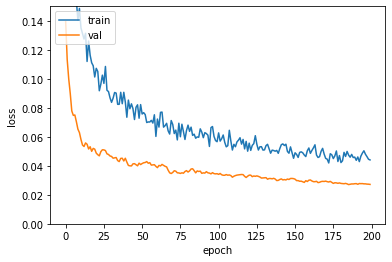

Train Score:  0.02831302210688591
Validataion Score:  0.02717888541519642
Test Score:  0.02717888541519642


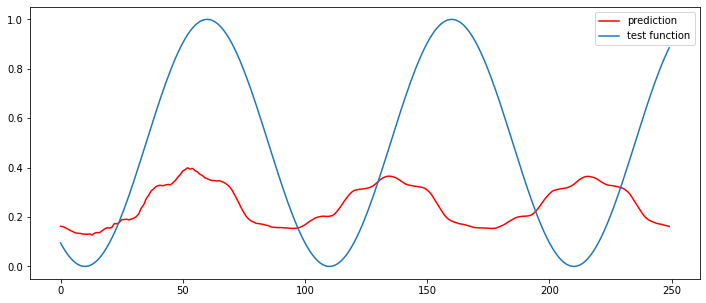

In [5]:
# 0. 사용할 패키지 불러오기
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
%matplotlib inline

def create_dataset(signal_data, look_back=1):
    dataX, dataY = [], []
    for i in range(len(signal_data)-look_back):
        dataX.append(signal_data[i:(i+look_back), 0])
        dataY.append(signal_data[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

look_back = 40

# 1. 데이터셋 생성하기
signal_data = np.cos(np.arange(1600)*(20*np.pi/1000))[:,None]

# 데이터 전처리
scaler = MinMaxScaler(feature_range=(0, 1))
signal_data = scaler.fit_transform(signal_data)

# 데이터 분리
train = signal_data[0:800]
val = signal_data[800:1200]
test = signal_data[1200:]

# 데이터셋 생성
x_train, y_train = create_dataset(train, look_back)
x_val, y_val = create_dataset(val, look_back)
x_test, y_test = create_dataset(test, look_back)

# 데이터셋 전처리
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

x_train = np.squeeze(x_train)
x_val = np.squeeze(x_val)
x_test = np.squeeze(x_test)

# 2. 모델 구성하기
model = Sequential()
model.add(Dense(32,input_dim=40,activation="relu"))
model.add(Dropout(0.3))
for i in range(2):
    model.add(Dense(32,activation="relu"))
    model.add(Dropout(0.3))
model.add(Dense(1))

# 3. 모델 학습과정 설정하기
model.compile(loss='mean_squared_error', optimizer='adagrad')

# 4. 모델 학습시키기
hist = model.fit(x_train, y_train, epochs=200, batch_size=32, validation_data=(x_val, y_val))

# 5. 학습과정 살펴보기
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.ylim(0.0, 0.15)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
          
# 6. 모델 평가하기
trainScore = model.evaluate(x_train, y_train, verbose=0)
print('Train Score: ', trainScore)
valScore = model.evaluate(x_val, y_val, verbose=0)
print('Validataion Score: ', valScore)
testScore = model.evaluate(x_test, y_test, verbose=0)
print('Test Score: ', testScore)

# 7. 모델 사용하기
look_ahead = 250
xhat = x_test[0, None]
predictions = np.zeros((look_ahead,1))
for i in range(look_ahead):
    prediction = model.predict(xhat, batch_size=32)
    predictions[i] = prediction
    xhat = np.hstack([xhat[:,1:],prediction])
    
plt.figure(figsize=(12,5))
plt.plot(np.arange(look_ahead),predictions,'r',label="prediction")
plt.plot(np.arange(look_ahead),y_test[:look_ahead],label="test function")
plt.legend()
plt.show()

![img](http://tykimos.github.io/warehouse/2017-9-9-Time-series_Numerical_Input_Numerical_Prediction_Model_Recipe_17_4.png)

진폭은 조금 적게 나오지만 주기는 비슷하게 나오는 결과를 얻었습니다.

#### 순환신경망 모델

Epoch 1/200
24/24 [==============================] - 3s 41ms/step - loss: 0.1219 - val_loss: 0.0303
Epoch 2/200
24/24 [==============================] - 0s 20ms/step - loss: 0.0280 - val_loss: 0.0177
Epoch 3/200
24/24 [==============================] - 0s 21ms/step - loss: 0.0215 - val_loss: 0.0107
Epoch 4/200
24/24 [==============================] - 0s 21ms/step - loss: 0.0159 - val_loss: 0.0048
Epoch 5/200
24/24 [==============================] - 0s 20ms/step - loss: 0.0124 - val_loss: 9.8443e-04
Epoch 6/200
24/24 [==============================] - 0s 20ms/step - loss: 0.0103 - val_loss: 0.0012
Epoch 7/200
24/24 [==============================] - 1s 21ms/step - loss: 0.0085 - val_loss: 0.0011
Epoch 8/200
24/24 [==============================] - 1s 21ms/step - loss: 0.0084 - val_loss: 9.7512e-04
Epoch 9/200
24/24 [==============================] - 1s 21ms/step - loss: 0.0073 - val_loss: 5.0416e-04
Epoch 10/200
24/24 [==============================] - 0s 20ms/step - loss: 0.0071 - val_

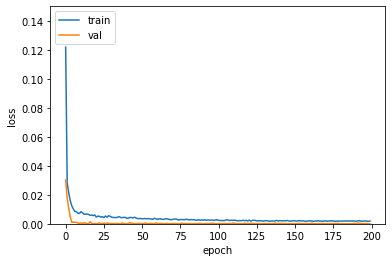

Train Score:  2.9161044949432835e-05
Validataion Score:  3.0201665140339173e-05
Test Score:  3.0201665140339173e-05


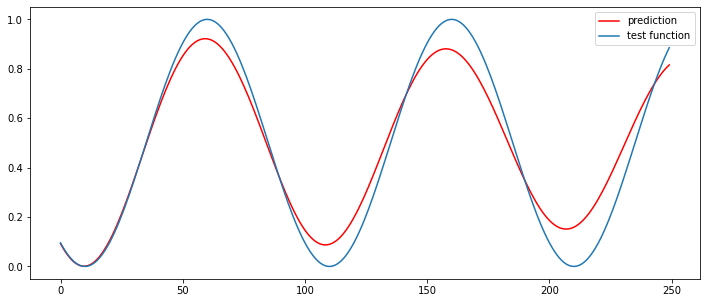

In [6]:
# 0. 사용할 패키지 불러오기
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
%matplotlib inline

def create_dataset(signal_data, look_back=1):
    dataX, dataY = [], []
    for i in range(len(signal_data)-look_back):
        dataX.append(signal_data[i:(i+look_back), 0])
        dataY.append(signal_data[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

look_back = 40

# 1. 데이터셋 생성하기
signal_data = np.cos(np.arange(1600)*(20*np.pi/1000))[:,None]

# 데이터 전처리
scaler = MinMaxScaler(feature_range=(0, 1))
signal_data = scaler.fit_transform(signal_data)

# 데이터 분리
train = signal_data[0:800]
val = signal_data[800:1200]
test = signal_data[1200:]

# 데이터셋 생성
x_train, y_train = create_dataset(train, look_back)
x_val, y_val = create_dataset(val, look_back)
x_test, y_test = create_dataset(test, look_back)

# 데이터셋 전처리
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# 2. 모델 구성하기
model = Sequential()
model.add(LSTM(32, input_shape=(None, 1)))
model.add(Dropout(0.3))
model.add(Dense(1))

# 3. 모델 학습과정 설정하기
model.compile(loss='mean_squared_error', optimizer='adam')

# 4. 모델 학습시키기
hist = model.fit(x_train, y_train, epochs=200, batch_size=32, validation_data=(x_val, y_val))

# 5. 학습과정 살펴보기
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.ylim(0.0, 0.15)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# 6. 모델 평가하기
trainScore = model.evaluate(x_train, y_train, verbose=0)
model.reset_states()
print('Train Score: ', trainScore)
valScore = model.evaluate(x_val, y_val, verbose=0)
model.reset_states()
print('Validataion Score: ', valScore)
testScore = model.evaluate(x_test, y_test, verbose=0)
model.reset_states()
print('Test Score: ', testScore)

# 7. 모델 사용하기
look_ahead = 250
xhat = x_test[0]
predictions = np.zeros((look_ahead,1))
for i in range(look_ahead):
    prediction = model.predict(np.array([xhat]), batch_size=1)
    predictions[i] = prediction
    xhat = np.vstack([xhat[1:],prediction])
    
plt.figure(figsize=(12,5))
plt.plot(np.arange(look_ahead),predictions,'r',label="prediction")
plt.plot(np.arange(look_ahead),y_test[:look_ahead],label="test function")
plt.legend()
plt.show()

![img](http://tykimos.github.io/warehouse/2017-9-9-Time-series_Numerical_Input_Numerical_Prediction_Model_Recipe_19_3.png)

초반에는 진폭과 주기가 비슷하게 가지만 후반부로 가면서 진폭도 커지고, 주기도 커지는 결과를 얻었습니다.

#### 상태유지 순환신경망 모델

760/760 [==============================] - 8s 10ms/step - loss: 0.0018 - val_loss: 1.7505e-04


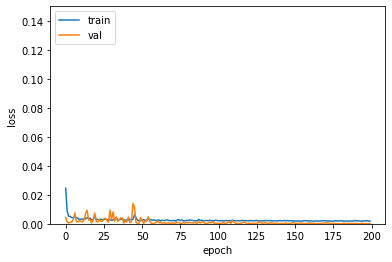

Train Score:  0.00018493355310056359
Validataion Score:  0.0001744262408465147
Test Score:  0.0001744262408465147


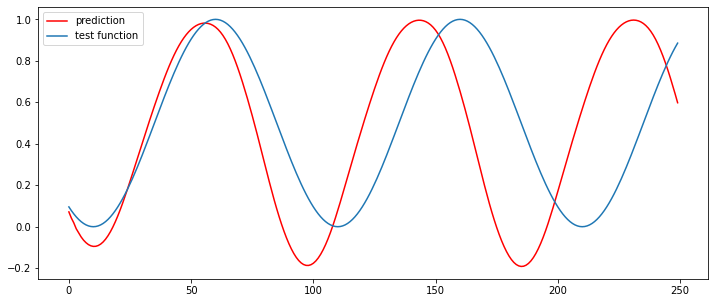

In [ ]:
# 0. 사용할 패키지 불러오기
import keras
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
%matplotlib inline

def create_dataset(signal_data, look_back=1):
    dataX, dataY = [], []
    for i in range(len(signal_data)-look_back):
        dataX.append(signal_data[i:(i+look_back), 0])
        dataY.append(signal_data[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

class CustomHistory(keras.callbacks.Callback):
    def init(self):
        self.train_loss = []
        self.val_loss = []
        
    def on_epoch_end(self, batch, logs={}):
        self.train_loss.append(logs.get('loss'))
        self.val_loss.append(logs.get('val_loss'))

look_back = 40

# 1. 데이터셋 생성하기
signal_data = np.cos(np.arange(1600)*(20*np.pi/1000))[:,None]

# 데이터 전처리
scaler = MinMaxScaler(feature_range=(0, 1))
signal_data = scaler.fit_transform(signal_data)

# 데이터 분리
train = signal_data[0:800]
val = signal_data[800:1200]
test = signal_data[1200:]

# 데이터셋 생성
x_train, y_train = create_dataset(train, look_back)
x_val, y_val = create_dataset(val, look_back)
x_test, y_test = create_dataset(test, look_back)

# 데이터셋 전처리
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# 2. 모델 구성하기
model = Sequential()
model.add(LSTM(32, batch_input_shape=(1, look_back, 1), stateful=True))
model.add(Dropout(0.3))
model.add(Dense(1))

# 3. 모델 학습과정 설정하기
model.compile(loss='mean_squared_error', optimizer='adam')

# 4. 모델 학습시키기
custom_hist = CustomHistory()
custom_hist.init()

for i in range(200):
    model.fit(x_train, y_train, epochs=1, batch_size=1, shuffle=False, callbacks=[custom_hist], validation_data=(x_val, y_val))
    model.reset_states()

# 5. 학습과정 살펴보기
plt.plot(custom_hist.train_loss)
plt.plot(custom_hist.val_loss)
plt.ylim(0.0, 0.15)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# 6. 모델 평가하기
trainScore = model.evaluate(x_train, y_train, batch_size=1, verbose=0)
model.reset_states()
print('Train Score: ', trainScore)
valScore = model.evaluate(x_val, y_val, batch_size=1, verbose=0)
model.reset_states()
print('Validataion Score: ', valScore)
testScore = model.evaluate(x_test, y_test, batch_size=1, verbose=0)
model.reset_states()
print('Test Score: ', testScore)

# 7. 모델 사용하기
look_ahead = 250
xhat = x_test[0]
predictions = np.zeros((look_ahead,1))
for i in range(look_ahead):
    prediction = model.predict(np.array([xhat]), batch_size=1)
    predictions[i] = prediction
    xhat = np.vstack([xhat[1:],prediction])
    
plt.figure(figsize=(12,5))
plt.plot(np.arange(look_ahead),predictions,'r',label="prediction")
plt.plot(np.arange(look_ahead),y_test[:look_ahead],label="test function")
plt.legend()
plt.show()

![img](http://tykimos.github.io/warehouse/2017-9-9-Time-series_Numerical_Input_Numerical_Prediction_Model_Recipe_21_3.png)

코사인 곡선의 패턴은 나오지만 동일 에포크와 동일 셀 크기의 순환신경망 모델에 비해 좋지 않은 결과를 얻었습니다. 

#### 상태유지 스택 순환신경망 모델

In [ ]:
# 0. 사용할 패키지 불러오기
import keras
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
%matplotlib inline

def create_dataset(signal_data, look_back=1):
    dataX, dataY = [], []
    for i in range(len(signal_data)-look_back):
        dataX.append(signal_data[i:(i+look_back), 0])
        dataY.append(signal_data[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

class CustomHistory(keras.callbacks.Callback):
    def init(self):
        self.train_loss = []
        self.val_loss = []
        
    def on_epoch_end(self, batch, logs={}):
        self.train_loss.append(logs.get('loss'))
        self.val_loss.append(logs.get('val_loss'))

look_back = 40

# 1. 데이터셋 생성하기
signal_data = np.cos(np.arange(1600)*(20*np.pi/1000))[:,None]

# 데이터 전처리
scaler = MinMaxScaler(feature_range=(0, 1))
signal_data = scaler.fit_transform(signal_data)

# 데이터 분리
train = signal_data[0:800]
val = signal_data[800:1200]
test = signal_data[1200:]

# 데이터셋 생성
x_train, y_train = create_dataset(train, look_back)
x_val, y_val = create_dataset(val, look_back)
x_test, y_test = create_dataset(test, look_back)

# 데이터셋 전처리
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# 2. 모델 구성하기
model = Sequential()
for i in range(2):
    model.add(LSTM(32, batch_input_shape=(1, look_back, 1), stateful=True, return_sequences=True))
    model.add(Dropout(0.3))
model.add(LSTM(32, batch_input_shape=(1, look_back, 1), stateful=True))
model.add(Dropout(0.3))
model.add(Dense(1))

# 3. 모델 학습과정 설정하기
model.compile(loss='mean_squared_error', optimizer='adam')

# 4. 모델 학습시키기
custom_hist = CustomHistory()
custom_hist.init()

for i in range(200):
    model.fit(x_train, y_train, epochs=1, batch_size=1, shuffle=False, callbacks=[custom_hist], validation_data=(x_val, y_val))
    model.reset_states()

# 5. 학습과정 살펴보기
plt.plot(custom_hist.train_loss)
plt.plot(custom_hist.val_loss)
plt.ylim(0.0, 0.15)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# 6. 모델 평가하기
trainScore = model.evaluate(x_train, y_train, batch_size=1, verbose=0)
model.reset_states()
print('Train Score: ', trainScore)
valScore = model.evaluate(x_val, y_val, batch_size=1, verbose=0)
model.reset_states()
print('Validataion Score: ', valScore)
testScore = model.evaluate(x_test, y_test, batch_size=1, verbose=0)
model.reset_states()
print('Test Score: ', testScore)

# 7. 모델 사용하기
look_ahead = 250
xhat = x_test[0]
predictions = np.zeros((look_ahead,1))
for i in range(look_ahead):
    prediction = model.predict(np.array([xhat]), batch_size=1)
    predictions[i] = prediction
    xhat = np.vstack([xhat[1:],prediction])
    
plt.figure(figsize=(12,5))
plt.plot(np.arange(look_ahead),predictions,'r',label="prediction")
plt.plot(np.arange(look_ahead),y_test[:look_ahead],label="test function")
plt.legend()
plt.show()

760/760 [==============================] - 24s 31ms/step - loss: 0.1034 - val_loss: 0.0013


![img](http://tykimos.github.io/warehouse/2017-9-9-Time-series_Numerical_Input_Numerical_Prediction_Model_Recipe_23_3.png)

진폭과 주기가 거의 유사한 형태의 결과를 얻었습니다. 최대 진폭은 비슷하게 나오지만 낮은 진폭은 조금 더 높게 나오는 경향이 있네요.

---

### 학습결과 비교

각 모델의 학습 과정 및 결과를 비교해보겠습니다. 실험적으로는 상태유지 순환신경망 모델이 결과는 좋으나 손실값 변화가 많이 일어나기 때문에 안정화 되는 시점을 살펴봐야 합니다.

|다층퍼셉트론 모델|순환신경망 모델|상태유지 순환신경망 모델|상태유지 스택 순환신경망 모델|
|:-:|:-:|:-:|:-:|
|![img](http://tykimos.github.io/warehouse/2017-9-9-Time-series_Numerical_Input_Numerical_Prediction_Model_Recipe_17_2.png)|![img](http://tykimos.github.io/warehouse/2017-9-9-Time-series_Numerical_Input_Numerical_Prediction_Model_Recipe_19_1.png)|![img](http://tykimos.github.io/warehouse/2017-9-9-Time-series_Numerical_Input_Numerical_Prediction_Model_Recipe_21_1.png)|![img](http://tykimos.github.io/warehouse/2017-9-9-Time-series_Numerical_Input_Numerical_Prediction_Model_Recipe_23_1.png)|
|![img](http://tykimos.github.io/warehouse/2017-9-9-Time-series_Numerical_Input_Numerical_Prediction_Model_Recipe_17_4.png)|![img](http://tykimos.github.io/warehouse/2017-9-9-Time-series_Numerical_Input_Numerical_Prediction_Model_Recipe_19_3.png)|![img](http://tykimos.github.io/warehouse/2017-9-9-Time-series_Numerical_Input_Numerical_Prediction_Model_Recipe_21_3.png)|![img](http://tykimos.github.io/warehouse/2017-9-9-Time-series_Numerical_Input_Numerical_Prediction_Model_Recipe_23_3.png)|

---

### Q & A

Q1) 상태유지 모드에서도 타임스텝이 필요한가요? 이전 학습된 배치의 상태를 알고 있기 때문에 타임스텝을 1로 설정해되 될 것 같습니다.

A1) ‘상태’는 이전까지 학습된 상태 중 기억해야할 정보를 함축적으로 표현한 것이고, 타임스텝은 해당 배치에서 직접적으로 입력해야 할 데이터입니다. 날씨 예보로 예를 들어보겠습니다. 몇 가지 가정을 해봅시다.
- 날마다 예보관은 다릅니다.
- 예보관은 오늘 날씨는 예보합니다.
- 오늘 날씨를 예보하기 위해 지난 4일치를 봅니다. (timestep=4)
오늘이 5일이라면 1일 2일 3일 4일 날씨를 보고 5일 날씨를 예보할 겁니다. 오늘 예보를 보기 위해서 지난 4일치만 보면 되기 때문에 상태유지 모델이 아니고 타임스텝이 4개인 LSTM 모델입니다. 여기서 5일 예보관이 오늘날씨를 예보하면서 메모를 남겼다고 가정합시다. 즉 "지난 4일 보니 이리저리했다. 곧 큰 비가 올 것 같다 등.." 6일 예보관은 지난 4일(2일, 3일, 4일, 5일)도 보지만 5일 예보관의 메모(state)도 참고해서 예보를 합니다. 6일 예보관이 메모를 보면 도움이 될 수 있는 이유가 6일 예보관한테는 1일 정보가 없기 때문이죠. 5일 예보관 메모에는 1일, 2일, 3일, 4일의 정보가 함축되어 있습니다. 6일 예보관의 메모는 어떨까요? 이 메모에는 2일, 3일, 4일, 5일 정보로 분석한 결과뿐만아니라 5일 예보관의 메모도 고려되어 있습니다. 즉 1일, 2일, 3일, 4일, 5일의 정보도 가지고 있다고 볼 수 있습니다. 이런식으로 10일 예보관은 6일, 7일, 8일, 9일을 직접적으로 보겠지만 1일~8일의 정보를 담은 9일 예보관의 메모(state)를 참고합니다.  예보관은 지난 4일치 데이터 밖에 못보지만 1주일 전에 태풍이 왔더던지, 가뭄이 왔다던지, 폭우가 있었다던지 등 기상 예보에 있어 중요한 이벤트를 메모를 통해 알 수 있습니다.

Q2) 상태유지 모드에서 배치사이즈의 의미는 무엇인가요?

A2) 기본적으로 상태유지 모드에서는 배치사이즈를 1로 설정합니다. 한 샘플을 학습한 후 그 상태를 다음 샘플 학습 시에 전달하기 위해서 입니다. 배치사이즈를 2로 설정하면 관리하는 상태가 2개가 됩니다. 즉 서로 다른 성격을 가지는 시계열자료 2벌이 있을 때 사용합니다. 예를 들어 주식 예측을 할 때, 종목이 3개라면 배치사이즈를 3으로 설정해야 합니다. 한 배치에 3개의 종목 샘플 하나씩을 학습하며, 3개의 상태가 업데이트 됩니다. 여기서 갱신되는 가중치는 모두 공유됩니다.

Q3) 상태유지 모드에서 배치사이즈에 따라 독립적인 상태를 관리한다면, 한 모델에 배치사이즈가 3으로 설정하는 것과 세 개의 모델을 사용하는 것과 어떤차이가 있나요?

A3) 한 전문가가 세 종목을 보는 것이랑 세 명의 전문가가 종목 하나씩 보는 것과 비슷합니다. 한 전문가가 여러 종목을 학습하게되면 종목별로 상태 관리를 하면서 여러가지 상황을 학습하게 되므로 좀 더 통찰력을 가지게 될 것 같습니다. 각 전문가가 종목별로 학습한다면 그 전문가는 그 종목에는 정통하겠지만, 전체적인 흐름이라던지 여러가지 상황에 대한 이해는 없을 겁니다.

---

### 요약

시계열 수치를 입력해서 다음 수치를 예측하기 위한 여러가지 모델을 살펴보았습니다. 시계열 데이터를 다루기 위해서 기본 순환신경망, 상태유지 모드 설정, 순환신경망 레이어를 쌓아올리는 방법을 알아보고 모델의 결과를 비교해봤습니다. 다양한 형태의 순환신경망 모델을 구성할 수 있는 만큼, 다루고 있는 시계열 데이터에 적합한 모델을 찾기 위해서는 여러가지 모델로 테스트 해보시기를 권장합니다. 

![img](http://tykimos.github.io/warehouse/2017-9-9-Time-series_Numerical_Input_Numerical_Prediction_Model_Recipe_total.png)

본 장은 https://github.com/sachinruk의 예제를 기반으로 작성되었으며, 예제 코드 사용을 흔쾌히 허락해주신 데이터사이언티스트 Sachin Abeywardana 박사님 감사드립니다.